# Baseline Elo xG Training

This notebook:
1. Loads WHL 2025 CSV data and aggregates shifts → games (sum for home_xg, away_xg)
2. Runs 70/30 block cross-validation (3 folds); grid search on first fold only
3. Reports mean +/- std of combined RMSE and win accuracy across runs
4. Generates Round 1 predictions from `WHSDSC_Rnd1_matchups.xlsx`
5. Saves outputs to `output/predictions/baseline_elo_xg/` and `output/models/baseline_elo_xg/`

**Baseline Elo xG** = same as Baseline Elo but uses expected goals (xG) for outcomes.

In [1]:
import pandas as pd
import numpy as np
import yaml
from itertools import product
import matplotlib.pyplot as plt
import json, os, sys, pathlib

# ---------- resolve python/ directory & set CWD ----------
_cwd = pathlib.Path(os.path.abspath('')).resolve()
if (_cwd / 'python').is_dir():
    _python_dir = _cwd / 'python'
elif _cwd.name == 'baseline_elo_xg' and (_cwd.parent.parent / 'data').is_dir():
    _python_dir = _cwd.parent.parent
elif _cwd.name == 'training' and (_cwd.parent / 'data').is_dir():
    _python_dir = _cwd.parent
elif (_cwd / 'data').is_dir():
    _python_dir = _cwd
else:
    raise RuntimeError(f'Cannot locate python/ directory from {_cwd}')

os.chdir(_python_dir)
sys.path.insert(0, str(_python_dir))

from utils.baseline_elo_xg import BaselineEloXGModel

plt.rcParams['figure.figsize'] = (12, 6)
print(f'CWD: {os.getcwd()}')

CWD: C:\Users\iscur\code\smiles\CSVy_wharton\python


C:\Users\iscur\code\smiles\CSVy_wharton\python\utils\xgboost_model.py:37: UserWarning: XGBoost not installed. Install with: pip install xgboost
  warnings.warn("XGBoost not installed. Install with: pip install xgboost")


## Load CSV Data & Aggregate to Games (xG)

In [2]:
# ── Load raw shift-level CSV and aggregate to game level (home_xg, away_xg) ──
raw = pd.read_csv('data/whl_2025.csv')
print(f'Raw: {len(raw)} shift rows')

games_df = raw.groupby('game_id').agg(
    home_team  = ('home_team', 'first'),
    away_team  = ('away_team', 'first'),
    home_xg    = ('home_xg', 'sum'),
    away_xg    = ('away_xg', 'sum'),
    went_ot    = ('went_ot', 'max'),
).reset_index()

# Sort by game_id (chronological)
extracted = games_df['game_id'].astype(str).str.extract(r'(\\d+)')
games_df['game_num'] = pd.to_numeric(extracted[0], errors='coerce').fillna(0).astype(int)
games_df = games_df.sort_values('game_num').reset_index(drop=True)

print(f'Games: {len(games_df)}')
print(f'Teams: {games_df["home_team"].nunique()}')
print(f'Avg home xG: {games_df["home_xg"].mean():.2f}, Avg away xG: {games_df["away_xg"].mean():.2f}')
print(f'Home xG win rate: {(games_df["home_xg"] > games_df["away_xg"]).mean():.1%}')
games_df.head()

Raw: 25827 shift rows
Games: 1312
Teams: 32
Avg home xG: 3.13, Avg away xG: 2.81
Home xG win rate: 60.6%


,game_id,home_team,away_team,home_xg,away_xg,went_ot,game_num
0,game_1,thailand,pakistan,2.8231,2.7516,0,0
1,game_10,switzerland,kazakhstan,1.9254,3.3189,0,0
2,game_100,serbia,rwanda,3.6712,3.0240,0,0
3,game_1000,brazil,netherlands,3.5905,2.5261,0,0
4,game_1001,india,morocco,3.4592,3.7658,0,0


## 70/30 Block CV & Grid Search (K-factor)

In [3]:
# Load config from YAML (proj_root has config/)
proj_root = _python_dir if (_python_dir / 'config').is_dir() else _python_dir.parent
config_path = proj_root / 'config' / 'hyperparams' / 'model_baseline_elo_xg.yaml'
if config_path.exists():
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    print(f'Config: {config["model_name"]} - {config["description"]}')
else:
    config = None
    print('Config not found, using defaults')

# 70/30 block cross-validation
val_cfg = config.get('validation', {}) if config else {}
TRAIN_RATIO = val_cfg.get('train_ratio', 0.7)
N_RUNS = val_cfg.get('n_runs', 3)
n_folds = N_RUNS
n = len(games_df)
test_size = int(n * (1 - TRAIN_RATIO))

def get_fold_splits(games_df, fold):
    """Block holdout: train ~70%, test ~30%. 3 folds = 3 different block positions."""
    if fold == 0:
        train_df = games_df.iloc[: n - test_size].copy()
        test_df = games_df.iloc[n - test_size :].copy()
    elif fold == 1:
        half = (n - test_size) // 2
        train_df = pd.concat([games_df.iloc[:half], games_df.iloc[half + test_size :]], ignore_index=True)
        test_df = games_df.iloc[half : half + test_size].copy()
    else:
        train_df = games_df.iloc[test_size:].copy()
        test_df = games_df.iloc[:test_size].copy()
    return train_df, test_df

# First fold for grid search
train_df, test_df = get_fold_splits(games_df, 0)
print(f'Split: {int(100*TRAIN_RATIO)}% train / {int(100*(1-TRAIN_RATIO))}% test, {n_folds} folds, ~{len(train_df)} train / ~{len(test_df)} test per fold')
print(f'Fold 1: Train {len(train_df)} games  |  Test {len(test_df)} games')

# Param grid from config
def _expand_param(val, default):
    if val is None: return default
    if isinstance(val, dict) and all(k in val for k in ('min','max','step')):
        return list(range(int(val['min']), int(val['max'])+1, int(val['step'])))
    return val if isinstance(val, list) else default

hp = config.get('hyperparameters', {}) if config else {}
param_grid = dict(
    k_factor       = _expand_param(hp.get('k_factor'), list(range(5, 101, 5))),
    initial_rating = _expand_param(hp.get('initial_rating'), [1200]),
)
formula_constants = {k: hp.get(k, {'elo_scale': 400, 'league_avg_goals': 3.0, 'goal_diff_half_range': 6.0}[k]) for k in ['elo_scale', 'league_avg_goals', 'goal_diff_half_range']}
keys = list(param_grid.keys())
combos = list(product(*[param_grid[k] for k in keys]))
print(f'Grid: {len(combos)} configurations')

Config: model_baseline_elo_xg - Classic Elo using xG (expected goals) for benchmarking
Split: 70% train / 30% test, 3 folds, ~919 train / ~393 test per fold
Fold 1: Train 919 games  |  Test 393 games
Grid: 20 configurations


In [4]:
# ── Grid Search (first fold only) with Brier & Log loss ──
results = []

for i, vals in enumerate(combos):
    params = dict(zip(keys, vals))
    params.update(formula_constants)
    label = f"BaselineEloXG(k={params['k_factor']},init={params['initial_rating']})"
    try:
        model = BaselineEloXGModel(params)
        model.fit(train_df)
        metrics = model.evaluate(test_df)
        brier_loss, log_loss = BaselineEloXGModel.compute_brier_logloss(model, test_df)
        results.append({'config': label, **params, **metrics, 'brier_loss': brier_loss, 'log_loss': log_loss})
    except Exception as e:
        print(f'  FAILED {label}: {e}')

results_df = pd.DataFrame(results).sort_values('combined_rmse')
best_row = results_df.iloc[0]
best_params = {
    'k_factor': int(best_row['k_factor']),
    'initial_rating': int(best_row['initial_rating']),
    **formula_constants,
}
k_metrics_df = results_df[['k_factor', 'win_accuracy', 'brier_loss', 'log_loss']].rename(
    columns={'k_factor': 'k', 'win_accuracy': 'accuracy'}
)
print(f'\n[OK] {len(results_df)} configs evaluated on fold 1')
print(f'Best: k={best_params["k_factor"]}, init={best_params["initial_rating"]} (combined_rmse={best_row["combined_rmse"]:.4f})')
results_df.head(10)[['config','home_rmse','away_rmse','combined_rmse','win_accuracy','brier_loss','log_loss']]


[OK] 20 configs evaluated on fold 1
Best: k=5, init=1200 (combined_rmse=0.9026)


,config,home_rmse,away_rmse,combined_rmse,win_accuracy,brier_loss,log_loss
0,"BaselineEloXG(k=5,init=1200)",0.963823,0.836843,0.902569,0.605598,0.238689,0.670270
1,"BaselineEloXG(k=10,init=1200)",1.033714,0.907767,0.972781,0.603053,0.236013,0.664523
2,"BaselineEloXG(k=15,init=1200)",1.110711,0.988444,1.051356,0.605598,0.236353,0.665211
3,"BaselineEloXG(k=20,init=1200)",1.176534,1.057276,1.118496,0.597964,0.237685,0.668284
4,"BaselineEloXG(k=25,init=1200)",1.230265,1.113118,1.173155,0.603053,0.239293,0.672174
5,"BaselineEloXG(k=30,init=1200)",1.274296,1.158603,1.217824,0.605598,0.240923,0.676266
6,"BaselineEloXG(k=35,init=1200)",1.311109,1.196441,1.255085,0.590331,0.242491,0.680336
7,"BaselineEloXG(k=40,init=1200)",1.342674,1.228760,1.286978,0.587786,0.243978,0.684316
8,"BaselineEloXG(k=45,init=1200)",1.370443,1.257120,1.315002,0.585242,0.245386,0.688204
9,"BaselineEloXG(k=50,init=1200)",1.395459,1.282632,1.340234,0.582697,0.246724,0.692021


In [5]:
# ── Multi-run evaluation (all folds with best params) ──
per_run_metrics = []

for fold in range(n_folds):
    train_f, test_f = get_fold_splits(games_df, fold)
    model = BaselineEloXGModel(best_params)
    model.fit(train_f)
    metrics = model.evaluate(test_f)
    per_run_metrics.append({
        'run': fold + 1,
        'combined_rmse': metrics['combined_rmse'],
        'win_accuracy': metrics['win_accuracy'],
    })
    print(f'Run {fold + 1}: combined_rmse={metrics["combined_rmse"]:.4f}, win_accuracy={metrics["win_accuracy"]:.1%}')

# Aggregate
rmse_vals = [m['combined_rmse'] for m in per_run_metrics]
acc_vals = [m['win_accuracy'] for m in per_run_metrics]
rmse_mean, rmse_std = np.mean(rmse_vals), np.std(rmse_vals)
acc_mean, acc_std = np.mean(acc_vals), np.std(acc_vals)

print(f'\nSummary (mean +/- std over {n_folds} runs):')
print(f'  Combined RMSE:  {rmse_mean:.4f} +/- {rmse_std:.4f}')
print(f'  Win Accuracy:   {acc_mean:.1%} +/- {acc_std:.1%}')

Run 1: combined_rmse=0.9026, win_accuracy=60.6%
Run 2: combined_rmse=0.9030, win_accuracy=60.1%
Run 3: combined_rmse=0.8219, win_accuracy=63.6%

Summary (mean +/- std over 3 runs):
  Combined RMSE:  0.8758 +/- 0.0381
  Win Accuracy:   61.4% +/- 1.6%


## Train Final Model & Rankings

In [6]:
# ── Train on ALL data with best params ──
final_model = BaselineEloXGModel(best_params)
final_model.fit(games_df)

print('Final Baseline Elo xG model trained on all', len(games_df), 'games')
print(f'\nCV metrics (mean +/- std over {n_folds} runs):')
print(f'  Combined RMSE:  {rmse_mean:.4f} +/- {rmse_std:.4f}')
print(f'  Win Accuracy:   {acc_mean:.1%} +/- {acc_std:.1%}')

print(f'\nTeam Rankings (top 10):')
for rank, (team, rating) in enumerate(final_model.get_rankings(10), 1):
    print(f'  {rank:2d}. {team:20s}  {rating:.1f}')

Final Baseline Elo xG model trained on all 1312 games

CV metrics (mean +/- std over 3 runs):
  Combined RMSE:  0.8758 +/- 0.0381
  Win Accuracy:   61.4% +/- 1.6%

Team Rankings (top 10):
   1. thailand              1282.2
   2. brazil                1261.3
   3. peru                  1253.0
   4. pakistan              1249.7
   5. mexico                1244.7
   6. uk                    1238.1
   7. netherlands           1236.7
   8. china                 1234.5
   9. france                1230.3
  10. panama                1223.1


[OK] output\predictions\baseline_elo_xg\baseline_elo_xg_ratings.png


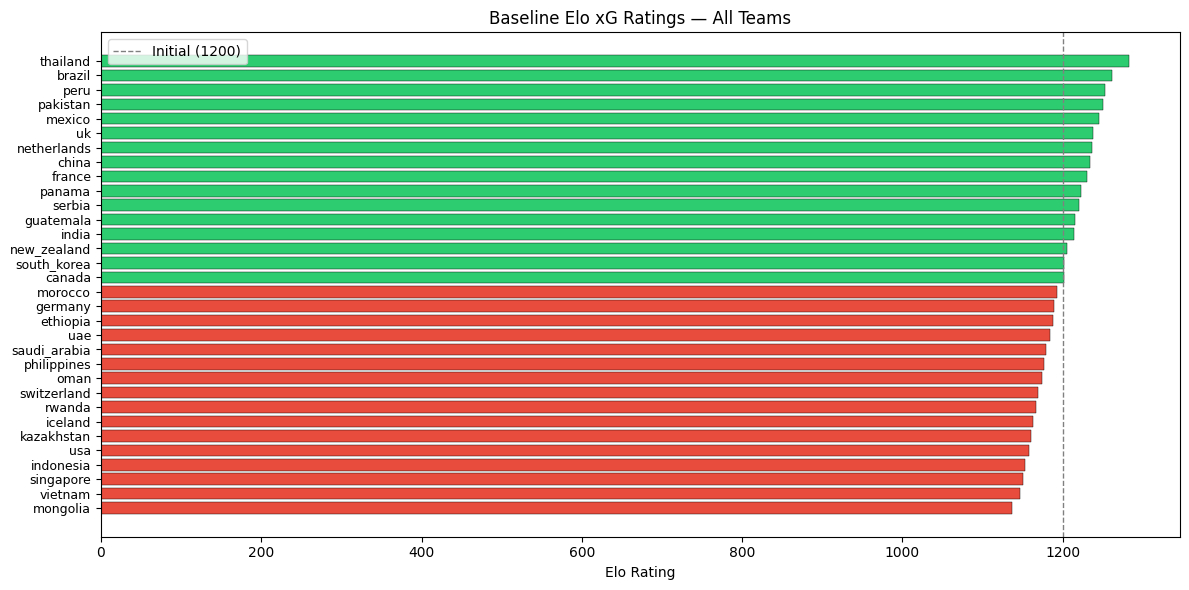

In [ ]:
# ── Rating distribution visualization ──
rankings = final_model.get_rankings()
teams_r, ratings_r = zip(*rankings)

fig, ax = plt.subplots(figsize=(12, 6))
initial_ref = best_params.get('initial_rating', 1200)
colors = ['#2ecc71' if r > initial_ref else '#e74c3c' if r < initial_ref else '#95a5a6' for r in ratings_r]
ax.barh(range(len(teams_r)), ratings_r, color=colors, edgecolor='black', linewidth=0.3)
ax.set_yticks(range(len(teams_r)))
ax.set_yticklabels(teams_r, fontsize=9)
ax.axvline(initial_ref, color='gray', ls='--', lw=1, label=f'Initial ({initial_ref})')
ax.set_xlabel('Elo Rating')
ax.set_title('Baseline Elo xG Ratings — All Teams')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
chart_path = pathlib.Path('output/predictions/baseline_elo_xg/baseline_elo_xg_ratings.png')
chart_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(chart_path, dpi=120, bbox_inches='tight')
print(f'[OK] {chart_path}')
plt.show()

## Round 1 Predictions

In [8]:
# ── Load Round 1 matchups and predict ──
matchups = pd.read_excel('data/WHSDSC_Rnd1_matchups.xlsx')
print(f'{len(matchups)} matchups loaded')

home_col = [c for c in matchups.columns if 'home' in c.lower()][0]
away_col = [c for c in matchups.columns if 'away' in c.lower()][0]

preds = []
for i, row in matchups.iterrows():
    game = {'home_team': row[home_col], 'away_team': row[away_col]}
    h_xg, a_xg = final_model.predict_goals(game)
    winner, conf = final_model.predict_winner(game)
    preds.append({
        'game': i + 1,
        'home_team': row[home_col],
        'away_team': row[away_col],
        'pred_home_xg': round(h_xg, 2),
        'pred_away_xg': round(a_xg, 2),
        'predicted_winner': winner,
        'confidence': round(conf, 4),
    })

pred_df = pd.DataFrame(preds)
print(f'\nRound 1 Baseline Elo xG Predictions:')
print(pred_df.to_string(index=False))
print(f'\nAvg confidence: {pred_df["confidence"].mean():.1%}')

16 matchups loaded

Round 1 Baseline Elo xG Predictions:
 game   home_team    away_team  pred_home_xg  pred_away_xg predicted_winner  confidence
    1      brazil   kazakhstan          3.85          2.15           brazil      0.6413
    2 netherlands     mongolia          3.84          2.16      netherlands      0.6405
    3        peru       rwanda          3.73          2.27             peru      0.6212
    4    thailand         oman          3.91          2.09         thailand      0.6510
    5    pakistan      germany          3.52          2.48         pakistan      0.5867
    6       india          usa          3.48          2.52            india      0.5805
    7      panama  switzerland          3.46          2.54           panama      0.5762
    8     iceland       canada          2.66          3.34           canada      0.5563
    9       china       france          3.04          2.96            china      0.5060
   10 philippines      morocco          2.86          3.14     

## Save Outputs

In [9]:
out_cfg = config.get('output', {}) if config else {}
out_dir = pathlib.Path(out_cfg.get('out_dir', 'output/predictions/baseline_elo_xg/xg'))
out_dir.mkdir(parents=True, exist_ok=True)
os.makedirs('output/models/baseline_elo_xg', exist_ok=True)

# 1. Grid search comparison CSV
comp_csv = out_cfg.get('comparison_csv', str(out_dir / 'comparison.csv'))
results_df.to_csv(comp_csv, index=False)
print(f'[OK] {comp_csv}')

# 2. K metrics CSV
k_csv = out_cfg.get('k_metrics_csv', str(out_dir / 'k_metrics.csv'))
k_metrics_df.to_csv(k_csv, index=False)
print(f'[OK] {k_csv}')

# 3. Round 1 predictions CSV
r1_csv = out_cfg.get('round1_csv', str(out_dir / 'round1_predictions.csv'))
pred_df.to_csv(r1_csv, index=False)
print(f'[OK] {r1_csv}')

# 4. Pipeline summary JSON
summary = {
    'model': 'BaselineEloXG',
    'train_ratio': TRAIN_RATIO,
    'n_runs': n_folds,
    'multi_run_metrics': {
        'combined_rmse_mean': round(rmse_mean, 6),
        'combined_rmse_std': round(rmse_std, 6),
        'win_accuracy_mean': round(acc_mean, 6),
        'win_accuracy_std': round(acc_std, 6),
    },
    'per_run_metrics': [
        {'run': m['run'], 'combined_rmse': round(m['combined_rmse'], 6), 'win_accuracy': round(m['win_accuracy'], 6)}
        for m in per_run_metrics
    ],
    'best_params': best_params,
    'team_rankings': {team: round(r, 1) for team, r in final_model.get_rankings()},
    'predictions': preds,
}
summary_json = out_cfg.get('summary_json', str(out_dir / 'pipeline_summary.json'))
with open(summary_json, 'w') as f:
    json.dump(summary, f, indent=2)
print(f'[OK] {summary_json}')

print(f'\nSUMMARY: Combined RMSE {rmse_mean:.4f} +/- {rmse_std:.4f}, Win Acc {acc_mean:.1%} +/- {acc_std:.1%}')

[OK] output/predictions/baseline_elo_xg/baseline_elo_xg_comparison.csv
[OK] output/predictions/baseline_elo_xg/baseline_elo_xg_k_metrics.csv
[OK] output/predictions/baseline_elo_xg/round1_baseline_elo_xg_predictions.csv
[OK] output/predictions/baseline_elo_xg/baseline_elo_xg_pipeline_summary.json

SUMMARY: Combined RMSE 0.8758 +/- 0.0381, Win Acc 61.4% +/- 1.6%
